# Objective of Analysis:
- `Geely Auto` aspires to enter `US market` by setting up a manufacturing unit and compete with the US and European counterparts
- As an `Automobile Consulting Company`, we should understand the factors that affect the pricing of cars in US market.
- Consulting Company should `model the price of cars` with available independent variables which will be used by the management to formulate their business strategy, manipulate design of the car, etc. to meet certain price levels.

# Understanding Data:
- `Cars` dataset with different specifications along with the price of each car is provided
- There are a total of 26 columns - in which, `price` column is the `predicted variable` and `other columns` are `predictor variables`
- There are a total of 205 records
- Dataset has continuous numerical, discrete numerical and ordinal categorical variables
- Dataset has a column `CarName` which contains car's company and model. We can derive company and model columns from it.
- There are no  missing values in the dataset

# Data Preparation
- Derive `company` and `model` columns from `CarName`. Observe that `subaru` company doesn't have a model.
- Fix `mis-spelt` company names in `company` column
- Fix character `casing` issues in `company` column
- Since `model` name of the car depends upon the specifications, it will be redundant variable and hence, we can drop it
- `car_ID` column is a counter and doesn't add any value to our analysis. Hence, drop it

# Exploratory Data Analysis and Data Visualization:
- Perform `Univariate Analysis` on all `numeric` columns using `violin` plots
- Perform `Univariate Analysis` on all `ordinal categorical` columns using pivot table, crosstab and frequency distributions
- Perform `Bivariate Analysis` on all `numeric` columns using `correlation heatmap` to identify strongly correlated variables
- Perform `Bivariate Analysis` using `box plots` for all `ordinal categorical` variables against price variables to understand the affects of each ordinal (sub-category)
- Plot `box` plots to `identify outliers` in the data for `numerical` variables
- Remove `outliers` for required variables using quantiles

# Model Building:
- Check for `unique` values for each variable - both numerical and categorical. 
    - Identify `discrete numerical` variables
    - Identify ordinal categorical variables that can be replaced with `binary` values - 0 and 1
    - Identify ordinal categorical variables that require `dummy` variables
- Create `dummy` features for all discrete numerical and ordinal categorical features
    - Dummy variables will now have a max value of 1 and min value of 0.
    - Drop the original features after creating dummy features.
- `Split` data into `train` and `test` sets
    - Model will be `built` using `train` dataset
    - Model will be `evaluated` using `test` dataset
- Rescale `train` set features
    - Since all our dummy variables are contain either 0 or 1, use `MinMaxScaler` for scaling other continuous numerical train set predictor features so that their values are scaled between 0 and 1
- Divide the train set into predictor features (x) and predicted feature (y)
    - For our model, predicted feature (y) is price
    - Other features are predictor features (x)
- After creating dummy variables, we will have so many features for creating our model. It will be very cubersome to iterate against all features
    - Use `Recursive Feature Elimination (RFE)` to eliminate unuseful features select the top 15 features that will be useful for our analysis
- Follow an iterative approach with the top 15 features selected through RFE and `compare models` using the following statistics:
    - `p-value` - lower is good - analyse for 95% confidence interval
    - `Adjusted R-square` - higher is good - explains the variance in train data
    - `F-Statistic` - higher is good - tests equality of variance among samples
    - Akaike Information Criterion (`AIC`) and Bayesian Information Criterion (`BIC`) values - lower is good - helps in selecting better model with optimal features
    - Variance Inflation Factor (`VIF`) - lower is good - explains multi-collinearity between features

# Model Evaluation:
- Perform `Residual Analysis`
    - Plot residuals using dist plot
    - Residuals must be `normally distributed` and `centered at 0`
- Rescale `test` features using `MinMaxScaler` for scaling all continuous numerial test set predictor features so that their values are scaled between 0 and 1
- Divide the test set into predictor features (x) and predicted feature (y)
    - For our model, predicted feature (y) is price
    - Other features are predictor features (x)
- `Predict` the price using the best model selected from model building step
- Plot a `scatter` plot for actual price and predicted price
    - Plotted data should follow a linear distribution
- Calculate `R-squared` - higher is good - that explains the variance between actual and predicted prices

## Import libraries and data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Split data into train and test
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# For Model Building
import statsmodels.api as sm

# For VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For r2_score
from sklearn.metrics import r2_score

In [9]:
cars = pd.read_csv('./CarPrice_Assignment.csv')
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [11]:
cars.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

Observe that there are no missing values in the dataset

## Functions - Data Manipulation

#### 1. Drop a given list of columns

In [12]:
def drop_cols(df, cols):
    df = df.drop(columns=cols)
    return df

#### 2. Get all numerical columns in a dataset

In [13]:
def get_all_num_cols(df):
    return df.select_dtypes(include=[np.number]).columns.tolist()

#### 3. Get all categorical columns in a dataset

In [14]:
def get_all_cat_columns(df):
    return df.select_dtypes(include=[np.object]).columns.tolist()

#### 4. Extract company and model from car name

In [15]:
def extract_company_and_model(name):
    args = name.split()
    company = args[0]
    model = ''
    if(len(args) > 2):
        model = ' '.join(args[1:len(args)])
    elif(len(args) > 1):
        model = args[1]
    else:
        model = 'NA'
    return {'company': company, 'model': model}

#### 5. Fix company name

In [16]:
def fix_company_name(x):
    if x == 'maxda':
        return 'mazda'
    elif x == 'Nissan':
        return 'nissan'
    elif x == 'porcshce':
        return 'porsche'
    elif x == 'toyouta':
        return 'toyota'
    elif x == 'vokswagen':
        return 'volkswagen'
    elif x == 'vw':
        return 'volkswagen'
    else:
        return x

#### 6. Get the list of all categorical columns with given no. of unique values

In [17]:
def get_cols_with_given_unique(df, n, col_type):
    cols = df.columns
    result = []
    for col in cols:
        if((df[col].dtype == col_type) & (len(df[col].unique()) == n)):
            result.append(col)
    return result

#### 7. Get the list of all columns with less than given no. of unique values

In [18]:
def get_cols_with_less_than_given_unique(df, n, col_type):
    cols = df.columns
    result = []
    for col in cols:
        if((df[col].dtype == col_type) & (len(df[col].unique()) <= n)):
            result.append(col)
    return result

## Functions - Plot Data

#### 1. Plot a correlation matrix of numerical columns against a target column

In [19]:
def plot_corr_matrix(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

#### 2. Plot dist plots of numerical columns in a dataset

In [20]:
def plot_dist(df, cols, nr_rows, nr_cols):
    j = 0

    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

    for r in range(0,nr_rows):
        for c in range(0,nr_cols):  
            i = r*nr_cols+c
            if i < len(cols):
                sns.distplot(df[cols[j]], ax = axs[r][c])
                j = j+1

    plt.tight_layout()    
    plt.show()

#### 3. Plot violin plots of numerical columns in a dataset

In [21]:
def plot_violin(df, cols, nr_rows, nr_cols):
    j = 0

    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

    for r in range(0,nr_rows):
        for c in range(0,nr_cols):  
            i = r*nr_cols+c
            if i < len(cols):
                sns.violinplot(df[cols[j]], data=df, ax = axs[r][c], orient='v')
                j = j+1

    plt.tight_layout()    
    plt.show()

#### 4. Plot box plots of columns in a dataset

In [22]:
def plot_box(df, cols, nr_rows, nr_cols):
    j = 0

    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

    for r in range(0,nr_rows):
        for c in range(0,nr_cols):  
            i = r*nr_cols+c
            if i < len(cols):
                sns.boxplot(df[cols[j]], data=df, ax = axs[r][c], orient='v')
                j = j+1

    plt.tight_layout()    
    plt.show()

#### 5. Plot box plots of a column against another column in a dataset

In [23]:
def plot_box_x_y(df, cols, y, nr_rows, nr_cols):
    j = 0

    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

    for r in range(0,nr_rows):
        for c in range(0,nr_cols):  
            i = r*nr_cols+c
            if i < len(cols):
                sns.boxplot(data=df, x=df[cols[j]], y=df[y], ax = axs[r][c], orient='v')
                j = j+1

    plt.tight_layout() 
    plt.xticks(rotation=90)   
    plt.show()

#### 6. Plot frequency dist plots for columns in a dataset

In [24]:
def plot_frequency_dist(df, cols, nr_rows, nr_cols):
    j = 0

    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

    for r in range(0,nr_rows):
        for c in range(0,nr_cols):  
            i = r*nr_cols+c
            if i < len(cols):
                sns.countplot(df[cols[j]], data=df, ax = axs[r][c], orient='v')
                plt.xticks(rotation=90)
                j = j+1

    plt.tight_layout()    
    plt.show()

# Data Preparation

In [25]:
# Check if all rows of CarName have both company and model
cars.loc[cars['CarName'].apply(lambda x: len(x.split()) < 2)]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
138,139,2,subaru,gas,std,two,hatchback,fwd,front,93.7,...,97,2bbl,3.62,2.36,9.0,69,4900,31,36,5118.0
141,142,0,subaru,gas,std,four,sedan,fwd,front,97.2,...,108,2bbl,3.62,2.64,9.5,82,4800,32,37,7126.0


Observe that `subaru` company doesn't have model information

In [26]:
# Extract company and model from CarName
cars = pd.concat([cars, cars['CarName'].apply(lambda x: pd.Series(extract_company_and_model(x)))], axis=1)

In [27]:
# Drop CarName as it will be redundant after deriving required information from it
cars = drop_cols(cars, ['CarName'])

In [28]:
# Print list of all unique company names
cars['company'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

#### Observe that there are few mis-spelt words for company names:
- maxda should be mazda
- Nissan shoule be nissan
- porcshce should be porsche
- toyouta should be toyota
- vokswagen should be volkswagen
- vw should be volkswagen

In [29]:
# Fix company name
cars['company'] = cars['company'].apply(fix_company_name)
cars['company'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [30]:
# Since model name of the car depends upon the specifications, it will be redundant variable and hence, we can drop it
cars = drop_cols(cars, ['model'])

In [31]:
# Dropping car_ID as it is just a serial number and doesn't have any significance
cars = drop_cols(cars, ['car_ID'])

# Exploratory Data Analysis

In [32]:
# Get list of all numerical columns
li_num_cols = get_all_num_cols(cars)
print(li_num_cols)

['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


In [33]:
# Get list of all categorical columns
li_cat_cols = get_all_cat_columns(cars)
print(li_cat_cols)

['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'company']


## Univariate Analysis - Numerical Columns
- Plot Box, Violin and Dist plots
- Remove outliers
    - Use quantile method to get values from 1, 2, 3 sigma away from mean
    - Remove the outliers

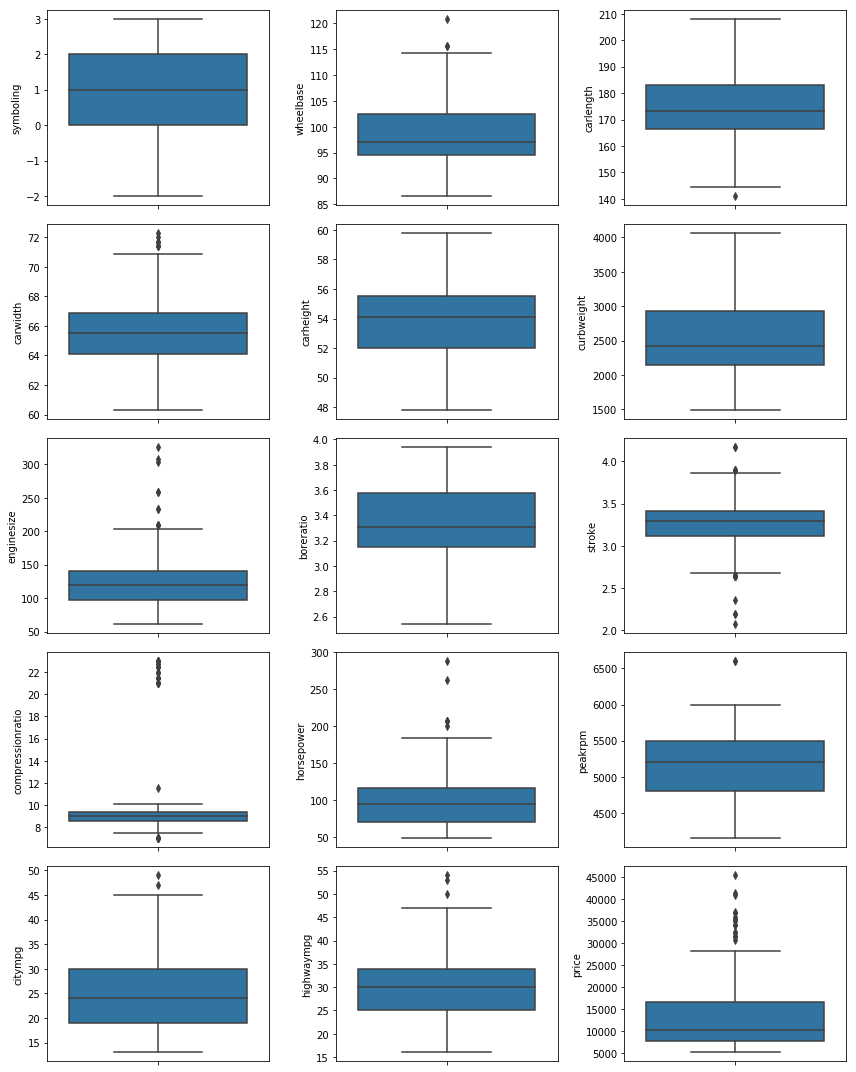

In [34]:
# Plot Box
plot_box(cars, li_num_cols, 5, 3)

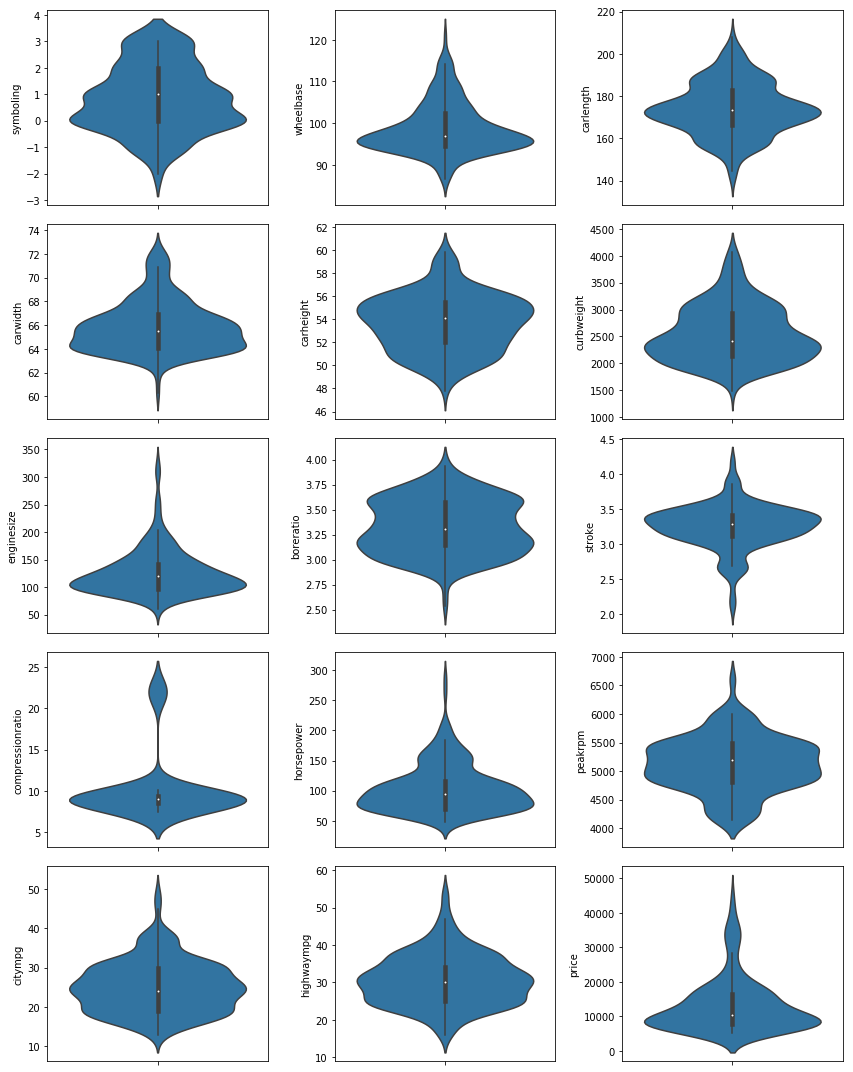

In [35]:
# Plot Violin
plot_violin(cars, li_num_cols, 5, 3)

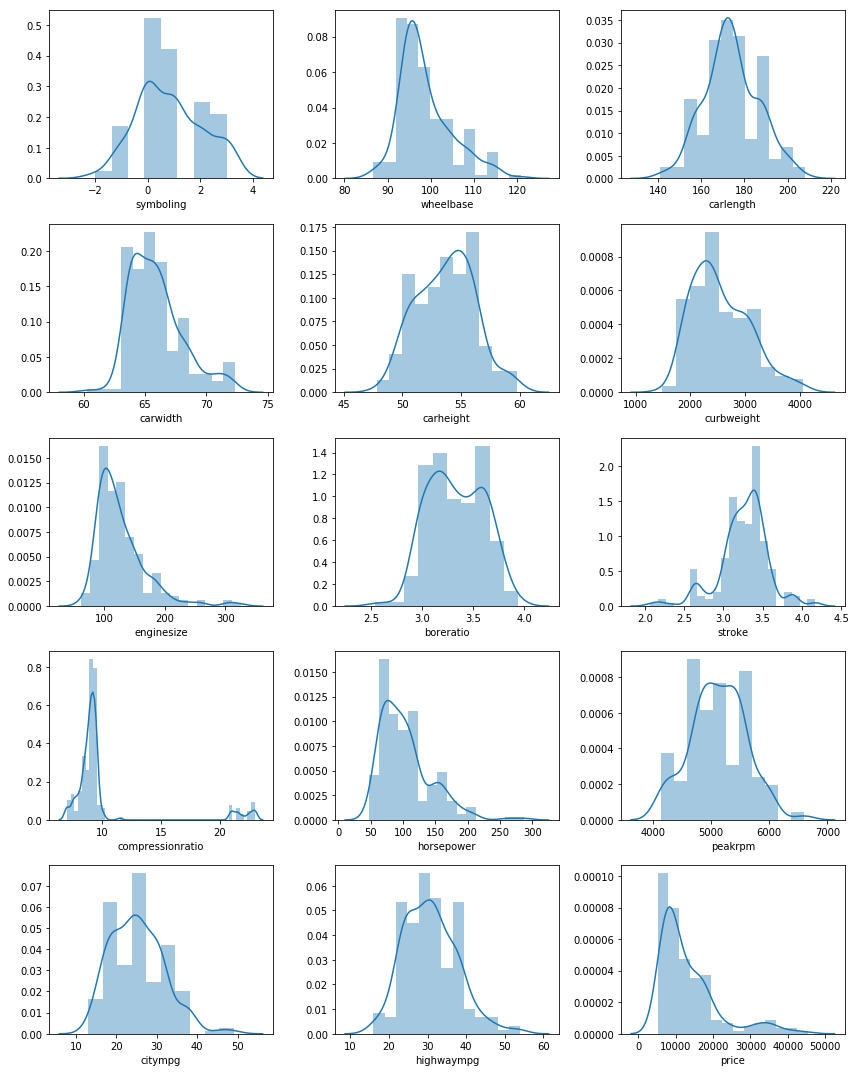

In [36]:
# Plot Dist
plot_dist(cars, li_num_cols, 5, 3)

### Observations:
- `compressionratio`, `horsepower`, `enginesize` and `stroke` have higher degree of outliers
- All other numerical variables have significant density in acceptable ranges i.e. (mean - 3 * std. deviation) to (mean + 3 * std. deviation)

### Treating outliers:
- Use quantile method to get values from 2 or 3 sigma away from mean

In [37]:
# Drop outliers for compressionratio
q = cars['compressionratio'].quantile(0.95)
cars = cars.loc[cars['compressionratio'] < q]

In [38]:
# Drop outliers for horsepower
q = cars['horsepower'].quantile(0.995)
cars = cars.loc[cars['horsepower'] < q]

In [39]:
# Drop outliers for enginesize
q = cars['enginesize'].quantile(0.95)
cars = cars.loc[cars['enginesize'] < q]

In [40]:
# Drop outliers for stroke
q = cars['stroke'].quantile(0.95)
cars = cars.loc[cars['stroke'] < q]

## Univariate Analysis - Categorical Variables
- Plot dist plots for all categorical variables

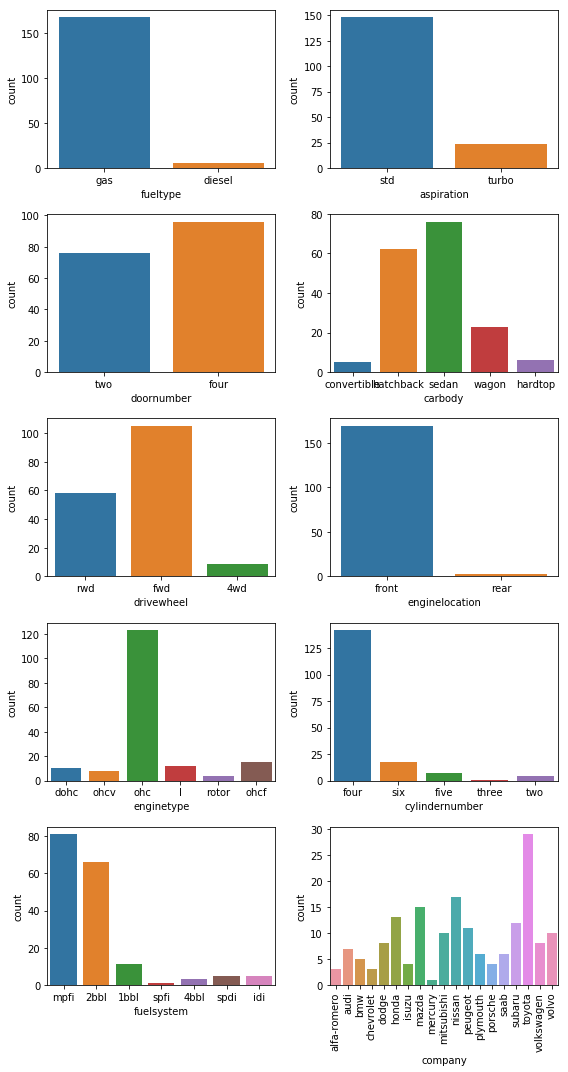

In [41]:
plot_frequency_dist(cars, li_cat_cols, 5, 2)

### Observations:
- fueltype `gas` is more popular than `diesel`
- aspiration `std` is more popular than `turbo`
- carbody `sedan` and `hatchback` are more popular than others
- drivewheel `fwd` is more popular
- enginelocation `front` is more popular than `rear`
- enginetype `ohc` is more popular than others
- cylindernumber `four` is more popular than others
- fuelsystem `mpfi` and `2bbl` are more popular than others
- company `toyota` is more popular than others

## Bivariate Analysis - Numerical Variables
- Plot a correlation heat map to identify strongly related variables with respect to price
- Plot pair plots

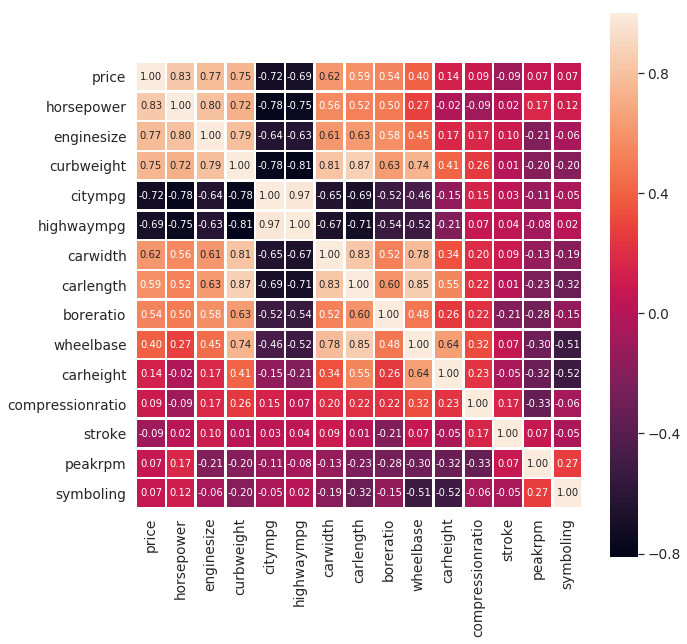

In [42]:
# Plot correlation matrix
plot_corr_matrix(cars, len(li_num_cols), 'price')

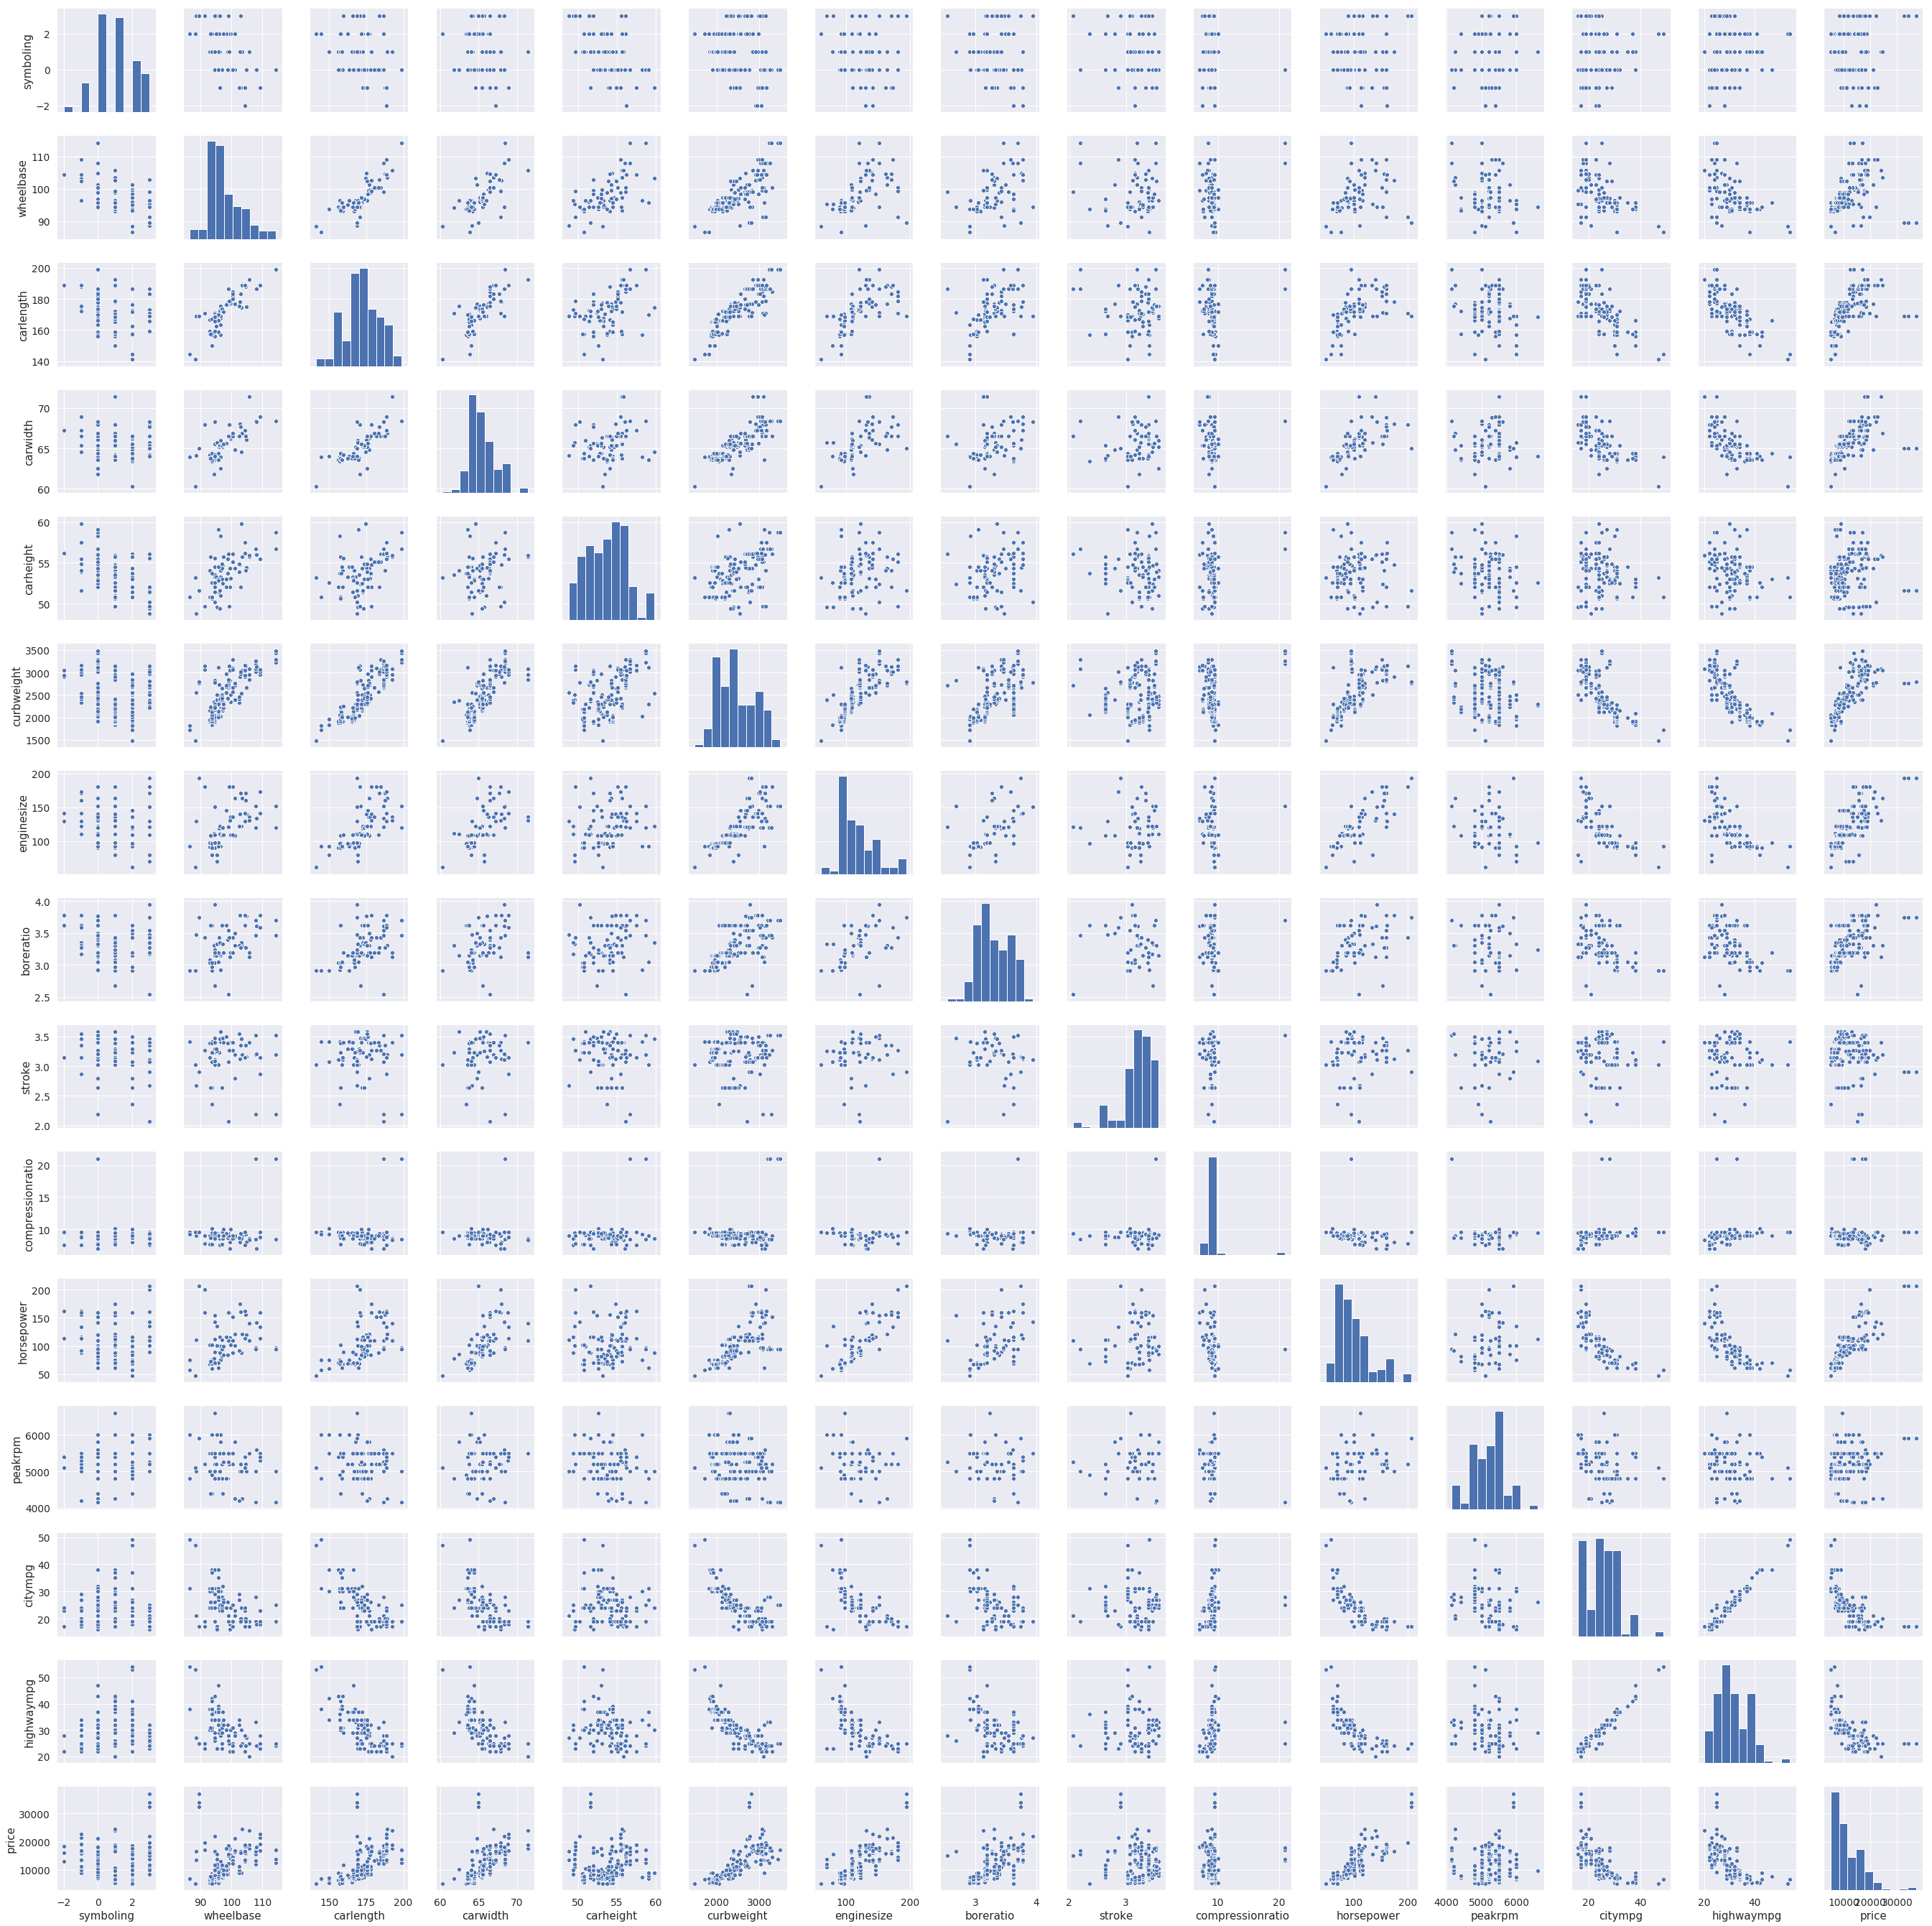

In [43]:
# Pair plot
sns.pairplot(cars)
plt.show()

### Observations:
- __Multi-Collinearity is visible__ as there are strongly correlated variables
    - carwidth and carlength
    - citympg and highwaymgp
    - others
- horsepower, enginesize, curbweight are strongly correlated with price
- carwidth, carlength and boreratio have average correlation with price
- citympg and highwaympg are negatively correlated with price
- citympg and highwaymgp are strongly correlated
- curbweight is strongly correlated with carwidth, carlength, wheelbase

Though we can drop some of the strongly correlated variables, let us not do it manually. We will use RFE for picking up the strong variables.

## Bivariate Analysis - Categorical Variables
- Plot `box` plots for all categorical variables against price

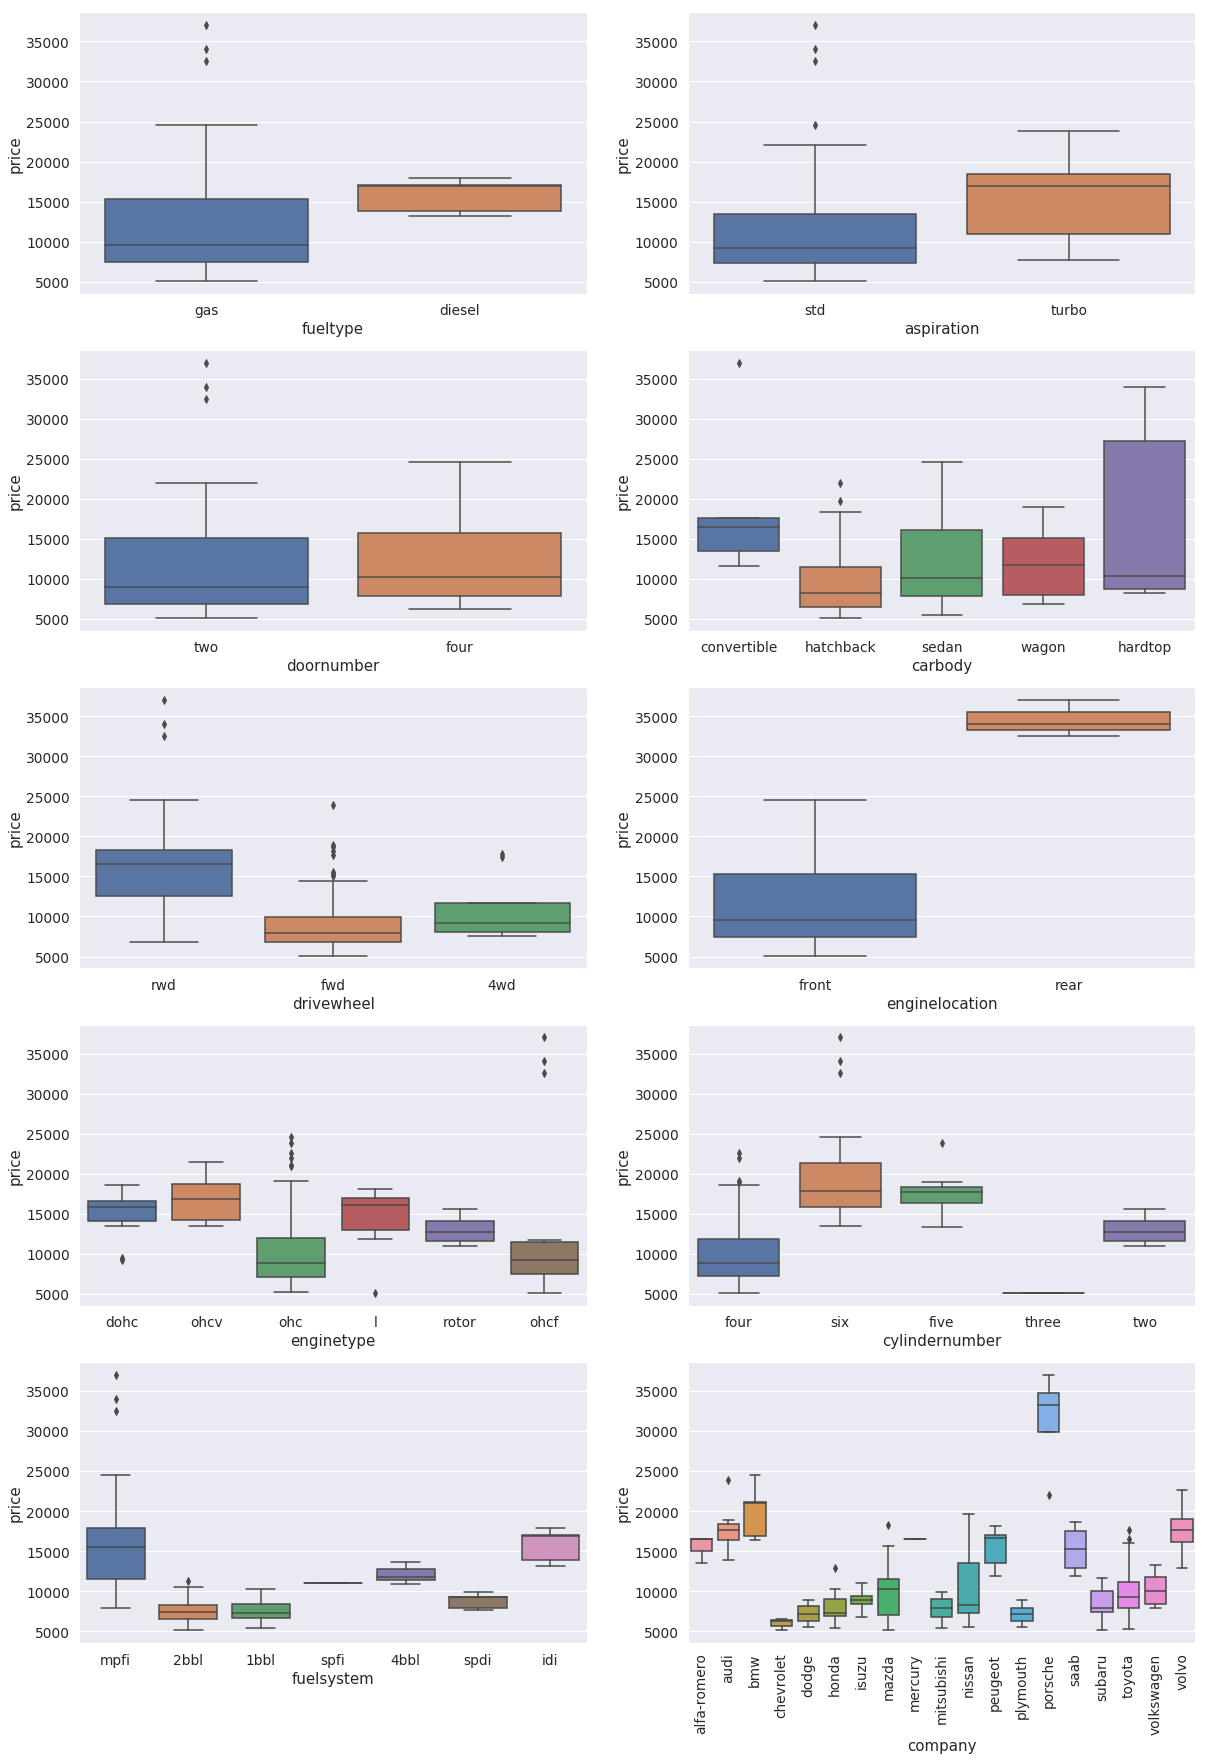

In [44]:
# Plot box
#plot_box_x_y(cars, li_cat_cols, 'price', 5, 2)
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
sns.boxplot(x = 'fueltype', y = 'price', data = cars)
plt.subplot(5,2,2)
sns.boxplot(x = 'aspiration', y = 'price', data = cars)
plt.subplot(5,2,3)
sns.boxplot(x = 'doornumber', y = 'price', data = cars)
plt.subplot(5,2,4)
sns.boxplot(x = 'carbody', y = 'price', data = cars)
plt.subplot(5,2,5)
sns.boxplot(x = 'drivewheel', y = 'price', data = cars)
plt.subplot(5,2,6)
sns.boxplot(x = 'enginelocation', y = 'price', data = cars)
plt.subplot(5,2,7)
sns.boxplot(x = 'enginetype', y = 'price', data = cars)
plt.subplot(5,2,8)
sns.boxplot(x = 'cylindernumber', y = 'price', data = cars)
plt.subplot(5,2,9)
sns.boxplot(x = 'fuelsystem', y = 'price', data = cars)
plt.subplot(5,2,10)
sns.boxplot(x = 'company', y = 'price', data = cars)
plt.xticks(rotation=90)
plt.show()

### Observations:
- `diesel` cars are more costlier than `gas` cars
- cars having `turbo` aspiration are more costlier than that of `std`
- doornumber doesn't have impact on price of cars
- `hardtop` carbody is costlier than others
- drivewheel - `rwd` cars are significantly costlier than fwd and 4wd
- cars having `rear` engines are more costlier than that of `front`
- cars having - Though there is an overlap between `five/six` cylinders, this still can be significant in determining car price
- `porsche` cars are more costlier

# Model Building:
- Create dummy variables
- Split data into `train` and `test` sets
- Use RFE for feature selection
- Iterate using each feature and compare models using statistics - __Adj. R-squared, F-statistic, AIC/BIC__
- Drop insignificant predictor variable - __one at a time__
- Follow below steps while dropping a predictor variable:
    - Check for p-value
        - &gt; 0.05 drop it
    - Check for VIF (Variance Inflation Factor)
        - Lower is better
            - &gt; 10 definitely drop
            - 5-10 recheck and potential candidate for dropping
            - &lt; 5 keep it
- Perform multiple iterations until all insignificant variables are removed using their p-value and VIF

## Create Dummy Variables:
- Identify ordinal categorical and discrete numerical columns
- Create dummy variables

### Identifying unique values for all columns:
- This is important for creating dummy variables

In [45]:
# Get the list of all categorical columns with 2 unique values
get_cols_with_given_unique(cars, 2, np.object)

['fueltype', 'aspiration', 'doornumber', 'enginelocation']

In [46]:
# Get the list of all numerical columns with 2 unique values
get_cols_with_less_than_given_unique(cars, 10, np.int64)

['symboling']

In [47]:
cars['symboling'].unique()

array([ 3,  1,  2,  0, -1, -2])

In [48]:
# Get the list of all categorical columns with less than 20 unique values
get_cols_with_less_than_given_unique(cars, 20, np.object)

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'company']

### Observations:
- 4 categorical columns `fueltype`, `aspiration`, `doornumber`, `enginelocation` have 2 unique values. These columns can have binary data
- 6 categorical columns `carbody`, `drivewheel`, `enginetype`, `cylindernumber`, `fuelsystem`, `company` are also ordinal. Hence, we should create dummy variables for them
- 1 numerical column `symboling` has 6 unique values. Hence, we should create dummy variables for this variable as well.

### Create Dummy Variables
- 4 will have binary values
- 7 will have new columns with dummy variables

In [49]:
# Modify fueltype
cars['fueltype'] = cars['fueltype'].apply(lambda x: 1 if x == 'gas' else 0)

In [50]:
# Modify aspiration
cars['aspiration'] = cars['aspiration'].apply(lambda x: 1 if x == 'std' else 0)

In [51]:
# Modify enginelocation
cars['enginelocation'] = cars['enginelocation'].apply(lambda x: 1 if x == 'front' else 0)

In [52]:
# Modify doornumber
cars['doornumber'] = cars['doornumber'].apply(lambda x: 1 if x == 'two' else 0)

In [53]:
# Create dummy variables for symboling
symbolings = pd.get_dummies(cars['symboling'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, symbolings], axis=1)

In [54]:
# Create dummy variables for carbody
carbodies = pd.get_dummies(cars['carbody'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, carbodies], axis=1)

In [55]:
# Create dummy variables for drivewheel
drivewheels = pd.get_dummies(cars['drivewheel'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, drivewheels], axis=1)

In [56]:
# Create dummy variables for enginetype
enginetypes = pd.get_dummies(cars['enginetype'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, enginetypes], axis=1)

In [57]:
# Create dummy variables for cylindernumber
cylinders = pd.get_dummies(cars['cylindernumber'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, cylinders], axis=1)

In [58]:
# Create dummy variables for fuelsystem
fuelsystems = pd.get_dummies(cars['fuelsystem'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, fuelsystems], axis=1)

In [59]:
# Create dummy variables for company
companies = pd.get_dummies(cars['company'], drop_first = True)

# Add above dummy variables to our dataset
cars = pd.concat([cars, companies], axis=1)

In [60]:
# Total no. of columns
len(cars.columns)

69

__Drop the columns for which dummy variables are created__. Otherwise, they will be redundant data.

In [61]:
# Drop columns
cars = drop_cols(cars, ['symboling', 'carbody', 'drivewheel', 'enginetype', 'cylindernumber', 'fuelsystem', 'company'])

In [62]:
# length of new cars dataset
len(cars.columns)

62

## Splitting data into Train and Test sets
- 70% of the data will be used to create a generic model and train it.
- 30% of the data will be used to test the model's accuracy

In [63]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
cars_train, cars_test = train_test_split(cars, train_size = 0.7, test_size = 0.3, random_state = 100)

## Rescaling the train set features
- __Scaling will not have any effect on statistics (p-value, etc.) of the model. However, it is important for _interpretation_.__
- Also, __Gradient Descent__ will converge faster if all the variables are on the _similar_ scale.
- We will use Min-Max Scaling as we want all our values to be between 0 and 1. Also, remember that our dummy variables also have 0 as minimum and 1 as maximum.
- Apply scaler to all the columns except the 'yes-no' and 'dummy' variables. Remember that even if we apply for yes-no and dummy variables, there won't be any effect as they already have 0 as min and 1 as max

In [64]:
# Create an object for MinMaxScaler
scaler = MinMaxScaler()

In [65]:
# Prepare the list of numeric columns that have to be scaled
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
# Remember that even if we apply for yes-no and dummy variables, there won't be any effect as they already have 0 as min and 1 as max
num_vars = ['wheelbase', 'carlength', 'carwidth', 'carheight','curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']

In [66]:
# Apply scaling for train set
cars_train[num_vars] = scaler.fit_transform(cars_train[num_vars])

In [67]:
cars_train.head()

,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,...,mitsubishi,nissan,peugeot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
116,0,0,0,1,0.771739,0.775322,0.687500,0.718182,0.860144,0.661290,...,0,0,1,0,0,0,0,0,0,0
58,1,1,1,1,0.315217,0.449355,0.406250,0.072727,0.408764,0.080645,...,0,0,0,0,0,0,0,0,0,0
173,1,1,0,1,0.572464,0.570902,0.489583,0.554545,0.304322,0.419355,...,0,0,0,0,0,0,0,1,0,0
113,1,1,0,1,1.000000,1.000000,0.687500,0.718182,0.879952,0.403226,...,0,0,1,0,0,0,0,0,0,0
152,1,1,0,1,0.329710,0.259669,0.187500,0.518182,0.117647,0.177419,...,0,0,0,0,0,0,0,1,0,0


In [68]:
cars_train.describe()

,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,...,mitsubishi,nissan,peugeot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
count,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.958333,0.841667,0.433333,0.97500,0.421347,0.529512,0.400521,0.449848,0.403436,0.396976,...,0.066667,0.091667,0.083333,0.033333,0.033333,0.041667,0.050000,0.141667,0.041667,0.058333
std,0.200664,0.366584,0.497613,0.15678,0.199693,0.204042,0.182252,0.230936,0.251162,0.218661,...,0.250490,0.289765,0.277544,0.180258,0.180258,0.200664,0.218859,0.350170,0.200664,0.235355
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.00000,0.286232,0.420810,0.236979,0.254545,0.215936,0.223790,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.00000,0.358696,0.511971,0.375000,0.481818,0.348139,0.399194,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.00000,0.500000,0.613260,0.489583,0.627273,0.590036,0.532258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Observe that the max value for all variables is 1 and min value is 0

__Splitting the train data to x (predictors) and y (predicted) variables for model building.__

In [69]:
y_train = cars_train.pop('price')
x_train = cars_train

In [70]:
y_train.head()

116    17950.0
58     15645.0
173     8948.0
113    16695.0
152     6488.0
Name: price, dtype: float64

In [71]:
x_train.head()

,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,...,mitsubishi,nissan,peugeot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
116,0,0,0,1,0.771739,0.775322,0.687500,0.718182,0.860144,0.661290,...,0,0,1,0,0,0,0,0,0,0
58,1,1,1,1,0.315217,0.449355,0.406250,0.072727,0.408764,0.080645,...,0,0,0,0,0,0,0,0,0,0
173,1,1,0,1,0.572464,0.570902,0.489583,0.554545,0.304322,0.419355,...,0,0,0,0,0,0,0,1,0,0
113,1,1,0,1,1.000000,1.000000,0.687500,0.718182,0.879952,0.403226,...,0,0,1,0,0,0,0,0,0,0
152,1,1,0,1,0.329710,0.259669,0.187500,0.518182,0.117647,0.177419,...,0,0,0,0,0,0,0,1,0,0


# Feature selection using RFE
- From the 65 columns above, picking the top 15 columns
- Perform RFE

In [72]:
# Running RFE with output no. of the variables equal to 15

# Fit the model to the dataset we have
lm = LinearRegression()
lm.fit(x_train, y_train)

# RFE needs fitted model and the no. of top n features that we need from the list of all input variables
rfe = RFE(lm, 15)
rfe = rfe.fit(x_train, y_train)

In [73]:
# Display the column ranking selected by RFE
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('fueltype', True, 1),
 ('aspiration', False, 14),
 ('doornumber', False, 27),
 ('enginelocation', True, 1),
 ('wheelbase', False, 9),
 ('carlength', False, 21),
 ('carwidth', True, 1),
 ('carheight', False, 16),
 ('curbweight', True, 1),
 ('enginesize', False, 33),
 ('boreratio', False, 15),
 ('stroke', False, 39),
 ('compressionratio', True, 1),
 ('horsepower', False, 22),
 ('peakrpm', False, 35),
 ('citympg', False, 5),
 ('highwaympg', False, 6),
 (-1, False, 40),
 (0, False, 31),
 (1, False, 29),
 (2, False, 43),
 (3, False, 38),
 ('hardtop', True, 1),
 ('hatchback', False, 24),
 ('sedan', False, 26),
 ('wagon', False, 25),
 ('fwd', False, 44),
 ('rwd', True, 1),
 ('l', True, 1),
 ('ohc', False, 11),
 ('ohcf', True, 1),
 ('ohcv', False, 4),
 ('rotor', False, 34),
 ('four', False, 32),
 ('six', False, 3),
 ('three', False, 47),
 ('two', False, 37),
 ('2bbl', False, 13),
 ('4bbl', False, 18),
 ('idi', True, 1),
 ('mpfi', False, 12),
 ('spdi', False, 41),
 ('spfi', False, 7),
 ('audi

In [74]:
# Display the list of columns identified by RFE for further analysis
columns_by_rfe = x_train.columns[rfe.support_]
columns_by_rfe

Index(['fueltype', 'enginelocation', 'carwidth', 'curbweight',
       'compressionratio', 'hardtop', 'rwd', 'l', 'ohcf', 'idi', 'audi', 'bmw',
       'isuzu', 'porsche', 'subaru'],
      dtype='object')

### Observations
- Out of 15 columns:
    - 5 (audi, bmw, isuzu, porsche, subaru) are related to company
    - 1 (hardtop) is related to carbody
    - 1 (rwd) is related to wheeldrive
    - 2 (l, ohcf) are related to enginetype
    - 1 (idi) is related to fuelsystem
    - We have representation from 5 other features fueltype, enginelocation, carwidth, curbweight, compressionration

So, we have a good distribution of features that are selected by RFE

In [75]:
# Display the list of columns dis-regarded by RFE
x_train.columns[~rfe.support_]

Index(['aspiration', 'doornumber',  'wheelbase',  'carlength',  'carheight',
       'enginesize',  'boreratio',     'stroke', 'horsepower',    'peakrpm',
          'citympg', 'highwaympg',           -1,            0,            1,
                  2,            3,  'hatchback',      'sedan',      'wagon',
              'fwd',        'ohc',       'ohcv',      'rotor',       'four',
              'six',      'three',        'two',       '2bbl',       '4bbl',
             'mpfi',       'spdi',       'spfi',  'chevrolet',      'dodge',
            'honda',      'mazda',    'mercury', 'mitsubishi',     'nissan',
          'peugeot',   'plymouth',       'saab',     'toyota', 'volkswagen',
            'volvo'],
      dtype='object')

### Modify x_train to have only the columns selected by RFE

In [76]:
x_train_rfe = x_train[columns_by_rfe]

In [77]:
x_train_rfe.head()

,fueltype,enginelocation,carwidth,curbweight,compressionratio,hardtop,rwd,l,ohcf,idi,audi,bmw,isuzu,porsche,subaru
116,0,1,0.687500,0.860144,1.000000,0,1,1,0,1,0,0,0,0,0
58,1,1,0.406250,0.408764,0.171429,0,1,0,0,0,0,0,0,0,0
173,1,1,0.489583,0.304322,0.121429,0,0,0,0,0,0,0,0,0,0
113,1,1,0.687500,0.879952,0.100000,0,1,1,0,0,0,0,0,0,0
152,1,1,0.187500,0.117647,0.142857,0,0,0,0,0,0,0,0,0,0


## Model Building Iterations

### Iteration 1
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [78]:
x_train_rfe_1 = x_train_rfe

In [79]:
# Add constant
x_train_1 = sm.add_constant(x_train_rfe_1)

# Run linear model
lm_1 = sm.OLS(y_train, x_train_1).fit()

# Print summary of linear model
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           4.61e-55
Time:                        19:11:30   Log-Likelihood:                -1050.0
No. Observations:                 120   AIC:                             2128.
Df Residuals:                     106   BIC:                             2167.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.028e+04   1591.380  

#### Observations:
- Adj. R-squared is 92.2 % which is a good value
- AIC/BIC values are high - but unless we compare with other models, these values doesn't have any significance
- Diff of AIC and BIC is 45
- p-value for compressionratio is high

In [80]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_1
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
0,fueltype,inf
1,enginelocation,inf
8,ohcf,inf
9,idi,inf
14,subaru,inf
4,compressionratio,24.380000
3,curbweight,4.810000
13,porsche,4.230000
2,carwidth,4.020000
7,l,2.560000


#### Observations: 
- `fueltype` has infinite VIF. Hence, drop it for further analysis

### Iteration 2
- Drop `fueltype`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [81]:
# Drop rotor
x_train_rfe_2 = x_train_rfe_1.drop('fueltype', axis=1)

In [82]:
x_train_rfe_2.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'compressionratio',
       'hardtop', 'rwd', 'l', 'ohcf', 'idi', 'audi', 'bmw', 'isuzu', 'porsche',
       'subaru'],
      dtype='object')

In [83]:
# Add constant
x_train_2 = sm.add_constant(x_train_rfe_2)

# Run linear model
lm_2 = sm.OLS(y_train, x_train_2).fit()

# Print summary of linear model
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           4.61e-55
Time:                        19:11:34   Log-Likelihood:                -1050.0
No. Observations:                 120   AIC:                             2128.
Df Residuals:                     106   BIC:                             2167.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.25e+04   1142.287  

#### Observations:
- Nothing has changed since last model.
- Hence, `fueltype` indeed is a redundant variable

In [84]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_2
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
8,idi,28.40
0,enginelocation,25.76
3,compressionratio,24.38
7,ohcf,15.41
13,subaru,11.44
2,curbweight,4.81
12,porsche,4.23
1,carwidth,4.02
6,l,2.56
5,rwd,2.48


#### Observations:
- `idi` has higher VIF. Hence, drop it for further analysis

### Iteration 3
- Drop `idi`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [85]:
# Drop enginesize
x_train_rfe_3 = x_train_rfe_2.drop('idi', axis=1)

In [86]:
x_train_rfe_3.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'compressionratio',
       'hardtop', 'rwd', 'l', 'ohcf', 'audi', 'bmw', 'isuzu', 'porsche',
       'subaru'],
      dtype='object')

In [87]:
# Add constant
x_train_3 = sm.add_constant(x_train_rfe_3)

# Run linear model
lm_3 = sm.OLS(y_train, x_train_3).fit()

# Print summary of linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     117.7
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           7.52e-56
Time:                        19:11:38   Log-Likelihood:                -1050.7
No. Observations:                 120   AIC:                             2127.
Df Residuals:                     107   BIC:                             2164.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.203e+04   1058.393  

#### Observations:
- Adj. R-squared has not changed
- F-statistic has increased
- AIC/BIC values have increased very slightly.
- p-value for `compressionratio` is still higher

In [88]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_3
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
7,ohcf,14.23
12,subaru,10.80
0,enginelocation,9.42
2,curbweight,4.41
11,porsche,4.19
1,carwidth,4.01
5,rwd,2.39
6,l,2.29
3,compressionratio,1.67
4,hardtop,1.56


#### Observations:
- `ohcf` has higher VIF
- However, `compressionratio` is consistently having higher p-value
- Hence, dropping `compressionratio` for further analysis

### Iteration 4
- Drop `compressionratio`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [89]:
# Drop four
x_train_rfe_4 = x_train_rfe_3.drop('compressionratio', axis=1)

In [90]:
x_train_rfe_4.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'hardtop', 'rwd', 'l',
       'ohcf', 'audi', 'bmw', 'isuzu', 'porsche', 'subaru'],
      dtype='object')

In [91]:
# Add constant
x_train_4 = sm.add_constant(x_train_rfe_4)

# Run linear model
lm_4 = sm.OLS(y_train, x_train_4).fit()

# Print summary of linear model
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     129.0
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           8.07e-57
Time:                        19:11:40   Log-Likelihood:                -1050.9
No. Observations:                 120   AIC:                             2126.
Df Residuals:                     108   BIC:                             2159.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.196e+04   1051.568     11.

#### Observations:
- Adj. R-squared has not changed
- F-statistic has increased
- AIC/BIC decreased slightly
- p-values for all features are in acceptable range
- We can say that `compressionratio` indeed is a redundant variable

In [92]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_4
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
6,ohcf,14.19
11,subaru,10.78
0,enginelocation,8.18
2,curbweight,4.40
10,porsche,4.18
1,carwidth,3.99
4,rwd,2.39
5,l,1.61
3,hardtop,1.56
7,audi,1.41


#### Observations:
- `ohcf` has higher VIF now. Hence, dropping it for further analysis

### Iteration 5
- Drop `ohcf`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [93]:
# Drop four
x_train_rfe_5 = x_train_rfe_4.drop('ohcf', axis=1)

In [94]:
x_train_rfe_5.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'hardtop', 'rwd', 'l',
       'audi', 'bmw', 'isuzu', 'porsche', 'subaru'],
      dtype='object')

In [95]:
# Add constant
x_train_5 = sm.add_constant(x_train_rfe_5)

# Run linear model
lm_5 = sm.OLS(y_train, x_train_5).fit()

# Print summary of linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     129.0
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           8.07e-57
Time:                        19:11:42   Log-Likelihood:                -1050.9
No. Observations:                 120   AIC:                             2126.
Df Residuals:                     108   BIC:                             2159.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.123e+04   2036.823     10.

#### Observations:
- Nothing has changed since last model
- Hence, `ohcf` indeed is a redundant feature

In [96]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_5
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,carwidth,23.10
2,curbweight,15.36
0,enginelocation,8.16
4,rwd,3.64
5,l,1.76
9,porsche,1.54
6,audi,1.49
3,hardtop,1.43
8,isuzu,1.22
7,bmw,1.17


#### Observations:
- `carwidth` has higher VIF. Hence, dropping it for further analysis

### Iteration 6
- Drop `carwidth`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [97]:
# Drop four
x_train_rfe_6 = x_train_rfe_5.drop('carwidth', axis=1)

In [98]:
x_train_rfe_6.columns

Index(['enginelocation', 'curbweight', 'hardtop', 'rwd', 'l', 'audi', 'bmw',
       'isuzu', 'porsche', 'subaru'],
      dtype='object')

In [99]:
# Add constant
x_train_6 = sm.add_constant(x_train_rfe_6)

# Run linear model
lm_6 = sm.OLS(y_train, x_train_6).fit()

# Print summary of linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     121.8
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           2.15e-54
Time:                        19:11:45   Log-Likelihood:                -1059.9
No. Observations:                 120   AIC:                             2142.
Df Residuals:                     109   BIC:                             2172.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.027e+04   2170.538      9.

### Observations:
- Adj. R-squared and F-statistic dropped slightly
- AIC/BIC values increased slightly
- p-value for `subaru` turned higher

In [100]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_6
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,curbweight,8.17
0,enginelocation,4.21
3,rwd,3.64
4,l,1.73
8,porsche,1.50
2,hardtop,1.42
5,audi,1.26
6,bmw,1.14
7,isuzu,1.10
9,subaru,1.09


#### Observations:
- VIF for all variables is less than 10.
- p-value for `subaru` is higher. Hence, dropping it for further analysis

### Iteration 7:
- Drop `subaru`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [101]:
# Drop four
x_train_rfe_7 = x_train_rfe_6.drop('subaru', axis=1)

In [102]:
x_train_rfe_7.columns

Index(['enginelocation', 'curbweight', 'hardtop', 'rwd', 'l', 'audi', 'bmw',
       'isuzu', 'porsche'],
      dtype='object')

In [103]:
# Add constant
x_train_7 = sm.add_constant(x_train_rfe_7)

# Run linear model
lm_7 = sm.OLS(y_train, x_train_7).fit()

# Print summary of linear model
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     133.5
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           5.75e-55
Time:                        19:11:48   Log-Likelihood:                -1061.2
No. Observations:                 120   AIC:                             2142.
Df Residuals:                     110   BIC:                             2170.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.015e+04   2182.682      9.

#### Observations:
- Adj. R-squared decreased very slightly
- F-statistic has increased
- AIC/BIC values are same
- p-value for all features are in acceptable range

In [104]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_7
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,curbweight,8.16
0,enginelocation,4.02
3,rwd,3.60
4,l,1.73
8,porsche,1.50
2,hardtop,1.42
5,audi,1.26
6,bmw,1.14
7,isuzu,1.10


#### Observations:
- VIF for all features except `curbweight` are less than 5.
- VIF for `curbweight` is less than 10 which is still acceptable.
- Lets drop `curbweight` and see if the model give better results

### Iteration 8:
- Drop `curbweight`
- Rebuild model
- Observe Adj. R-squared, F-statistic, p-value, AIC, BIC, diffence of BIC and AIC and VIF

In [105]:
# Drop four
x_train_rfe_8 = x_train_rfe_7.drop('curbweight', axis=1)

In [106]:
x_train_rfe_8.columns

Index(['enginelocation', 'hardtop', 'rwd', 'l', 'audi', 'bmw', 'isuzu',
       'porsche'],
      dtype='object')

In [107]:
# Add constant
x_train_8 = sm.add_constant(x_train_rfe_8)

# Run linear model
lm_8 = sm.OLS(y_train, x_train_8).fit()

# Print summary of linear model
print(lm_8.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     48.81
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           6.79e-33
Time:                        19:11:53   Log-Likelihood:                -1119.4
No. Observations:                 120   AIC:                             2257.
Df Residuals:                     111   BIC:                             2282.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.413e+04   3496.707      6.

#### Observations:
- Adj. R-squared decreased significantly
- F-statistic decreased significantly
- AIC/BIC values increased significantly
- p-value for `l` increased significantly
- Hence `curbweight` shouldn't be dropped

In [108]:
# Calculate the VIF for above predictor variables
# Calculate VIFs
vif = pd.DataFrame()
x = x_train_rfe_8
vif['Features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,rwd,2.53
0,enginelocation,1.61
3,l,1.46
7,porsche,1.44
1,hardtop,1.42
5,bmw,1.14
6,isuzu,1.09
4,audi,1.08


#### Observations:
- VIF for all features are well below 5

### Iterations Conclusions:
- __Model #7 (Iteration 7)__ has given best results among all other models.
    - Adj. R-squared is 90.9 - so, it is able to explain more than 90% of variance
    - F-statistic is 133.5 - higher among all other models - hence, explains equality of sample variance better than other models
    - p-value for all features is less than 0.05 - that fits 95% confidence interval
    - AIC/BIC are lower when compared with other models. Hence this model is better with optimal no. of features
    - VIF for all features except 1 is less than 5. The other one has VIF less than 10. Hence, multi-collinearity is less

# Model Evaluation:
- Use __Model #7__
- Perform `residual analysis` on the `train` data
- `Predict` the price using `test` data
- Calculate R-squared for actual and predicted test data
- Plot the test price and predicted test price and observe for a `linear pattern`

## Residual Analysis
- Check if error terms follow a normal distribution centered at 0

Text(0.5,0,'Errors')

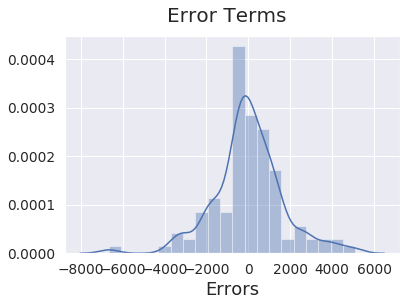

In [109]:
# For Iteration #7, get the predicted price
y_train_price_7 = lm_7.predict(x_train_7)

# Plot the histogram of the error terms (residuals)
fig = plt.figure()
sns.distplot((y_train - y_train_price_7), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   

### Observations:
- Residuals are normally distributed
- Residuals are centered approximately at 0
- Hence Model #7 is indeed a better model

## Model Predictions
- Use `test` data and `Model #7` to predict the "price"
- Scale the features of test data
- Predict the price

In [110]:
# Scale the numeric values of test data
cars_test[num_vars] = scaler.transform(cars_test[num_vars])

__Dividing into X and Y sets__

In [111]:
y_test = cars_test.pop('price')
x_test = cars_test

In [112]:
y_test.head()

7      18920.0
149    11694.0
11     16925.0
18      5151.0
156     6938.0
Name: price, dtype: float64

In [113]:
x_test.head()

,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,...,mitsubishi,nissan,peugeot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
7,1,1,0,1,0.695652,0.885820,1.000000,0.627273,0.681273,0.532258,...,0,0,0,0,0,0,0,0,0,0
149,1,0,0,1,0.373188,0.534070,0.375000,0.554545,0.498800,0.306452,...,0,0,0,0,0,0,1,0,0,0
11,1,1,0,1,0.528986,0.593002,0.312500,0.500000,0.345738,0.306452,...,0,0,0,0,0,0,0,0,0,0
18,1,1,1,1,0.065217,-0.064457,-0.156250,0.400000,-0.198679,-0.072581,...,0,0,0,0,0,0,0,0,0,0
156,1,1,0,1,0.329710,0.399632,0.270833,0.381818,0.157263,0.225806,...,0,0,0,0,0,0,0,1,0,0


In [114]:
# Prediction on Iteration #7
x_test_new_7 = x_test[x_train_rfe_7.columns]
x_test_new_7 = sm.add_constant(x_test_new_7, has_constant='add')
y_pred_7 = lm_7.predict(x_test_new_7)

## Observe for linear pattern:
- Plot scatter plot and fit Model #7
- Check if the Model #7 line appears decent enough to cover most data points
- __Calculate R-squared__ as mentioned in the problem statement

Text(0,0.5,'Predicted Price')

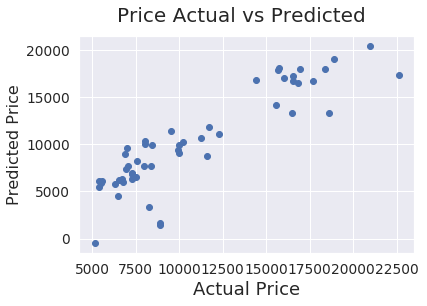

In [115]:
# For Iteration #7
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred_7)
fig.suptitle('Price Actual vs Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Actual Price', fontsize=18)                          # X-label
plt.ylabel('Predicted Price', fontsize=16)                          # Y-label

## Calculate r2_score:

In [117]:
r2_score(y_test, y_pred_7)

0.744155283548348

# Model Interpretations:


Equation of our best fitted line is:

$ price = 20150 + 13030  \times  curbweight +  6866  \times  porsche + 5858.4  \times  bmw + 4883.77 \times audi + 2331 \times rwd - 14830 \times enginelocation - 4338.6 \times isuzu - 3400.9 \times hardtop - 3251.01 \times l $


- `Company or Brand` of the car has significant impact on the price as we can see that world renowened brands `porsche`, `bmw` and `audi` have positive impact whereas `isuzu` had a negative impact on the price of car. Hence `Geely Auto` must have a strong brand image.
- `curbweight` of the car has high impact on the price. Having an ideal curb weight is very important. It shouldn't be too heavier (less efficient, high maintenance, less mileage, etc). At the same time, achieving lighter curb weight with all safety measures will require expensive parts
- `Rear Wheel Drive` can shoot up the price of the car as the engine completely has to be shifted from front to rear
- `l series (inline) engine types` are lighter, less noisier and easier to build when compared to V6 engines and hence, they cost less.
- `hardtop` cars have a negative impact on the price which means that hardtop cars cost `less` than other types of cars because they are common and doesn't require any aerodynamic, etc. design modifications.
- `enginelocation` has higher negative impact on the price of the car. Usually, cars having `rear` engines are very expensive for regular people's daily commuting. Whereas, `front` engine cars cost less.

# Conclusions:

- Selected Model #7 linear regression line is observing a linear behavior for most part.
- It was able to explain approx. 75% of the variance in actual vs predicted. Hence, there is variance that the model is unable to explain.
- It is a good linear model. However, for a better model, we could either add more domain specific features or use a non-linear model